In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LogNorm
import os

from hazma.scalar_mediator import ScalarMediator, HiggsPortal, HeavyQuark
from hazma.pseudo_scalar_mediator import PseudoScalarMFV
from hazma.vector_mediator import VectorMediator, KineticMixing, QuarksOnly

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_parameters import (energy_res_fermi, energy_res_e_astrogam,
                                        A_eff_e_astrogam, A_eff_comptel,
                                        egret_diffuse, fermi_diffuse,
                                        comptel_diffuse, gc_target,
                                        gc_bg_model, solid_angle)
from hazma.cmb import vx_cmb
from utilities import latex_text_width_1col

colors = [c["color"] for c in list(plt.rcParams["axes.prop_cycle"])]
constraint_names = ["COMPTEL", "EGRET", "Fermi", "e-ASTROGAM", "CMB"]

## Profiling

In [2]:
# import cProfile

# sm = HiggsPortal(mx=1., ms=500., gsxx=1., stheta=0.1)

# # Masses to scan over
# mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
# sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

# cProfile.run('sm_lims_egret = sm.binned_limits(sm_mxs, egret_diffuse)')

# Relic density curve

In [127]:
rd_mxs_s_wave, rd_lims_s_wave = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs_s_wave = 1e3*10.**rd_mxs_s_wave  # convert GeV -> MeV
rd_lims_s_wave = 10.**rd_lims_s_wave

def rd_lim_fn_p_wave(mxs):
    """Computes approximate value of <sigma v>_0 (ie, in the Milky Way) required
    to give the correct relic abundance.
    
    Notes
    -----
    I'm using the logic of arXiv:1703.02546:
    * From arxiv:1308.2578, <sigma v>_fo ~ 6 x 10^-26 cm^3/s.
    * Velocity at freeze out is v_fo = sqrt(3 T_fo / m) ~ 0.4 (using T ~ mx/20).
    * <sigma v>_0 = <sigma v>_fo * (v_0 / v_fo)^2.
    """
    def helper(mx):
        return 6e-26 * (1e-3 / 0.4)**2
    
    return np.vectorize(helper)(mxs)

# Scalar mediator

In [148]:
def fn_prefix_scalar(sm):
    """Prefix for data files and figures.
    """
    return "sm_{}_ann_to_{}".format("hp" if sm.__class__ == HiggsPortal else "hq",
                                    "med" if sm.ms < 250 else "sm")

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Compute constraints

In [149]:
# sm = HiggsPortal(mx=1., ms=200., gsxx=1., stheta=0.1)
sm = HeavyQuark(mx=1., ms=200., gsxx=1., gsQ=0.1, mQ=1e3, QQ=1.)

# Prefix for data files and figures
fn_prefix = fn_prefix_scalar(sm)

In [49]:
sm_lims_e_astrogam = sm.unbinned_limits(sm_mxs, target_params=gc_target, bg_model=gc_bg_model)

In [50]:
sm_lims_egret = sm.binned_limits(sm_mxs, egret_diffuse)

In [51]:
sm_lims_egret = sm.binned_limits(sm_mxs, egret_diffuse)
sm_lims_comptel = sm.binned_limits(sm_mxs, comptel_diffuse)
sm_lims_fermi = sm.binned_limits(sm_mxs, fermi_diffuse)

In [52]:
# sm_lims_cmb = sm.cmb_limits(sm_mxs)

In [53]:
np.savetxt("data/{}_lims_egret.csv".format(fn_prefix),
           np.array([sm_mxs, sm_lims_egret]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_comptel.csv".format(fn_prefix),
           np.array([sm_mxs, sm_lims_comptel]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_fermi.csv".format(fn_prefix),
           np.array([sm_mxs, sm_lims_fermi]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_e_astrogam.csv".format(fn_prefix),
           np.array([sm_mxs, sm_lims_e_astrogam]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/{}_lims_cmb.csv".format(fn_prefix),
#            np.array([sm_mxs, sm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Plot constraints

In [181]:
# Load constraints
theories = np.array(
    [[HiggsPortal(1., ms, 1., stheta=0.1) for ms in [200., 500.]],
     [HeavyQuark(1., ms, 1., gsQ=0.1, mQ=1e3, QQ=1.) for ms in [200., 500.]]],
    dtype=np.object)

constraints = np.array(
    [[{} for _ in range(theories.shape[1])] for _ in range(theories.shape[0])],
    dtype=np.object)

for i in range(theories.shape[0]):
    for j in range(theories.shape[1]):
        for c in constraint_names:
            if c != "CMB":  # TODO: fix CMB constraints and remove this
                fn = "data/{}_lims_{}.csv".format(fn_prefix_scalar(theories[i, j]),
                                                  c.lower().replace("-", "_"))
                constraints[i, j][c] = np.loadtxt(fn, delimiter=",")[:, 1]

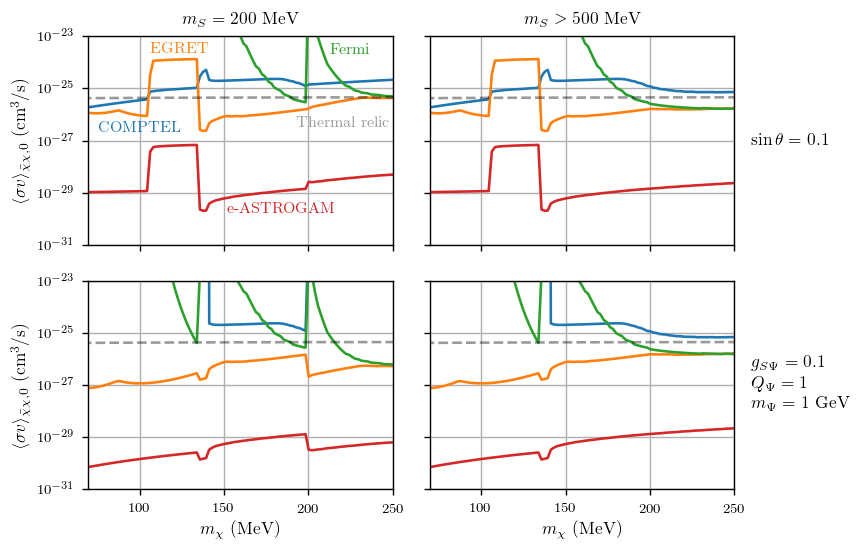

In [186]:
fig, axs = plt.subplots(theories.shape[0], theories.shape[1],
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col, 0.65*latex_text_width_1col))

for i in range(theories.shape[0]):
    for j in range(theories.shape[1]):
        ax = axs[i, j]
        
        # Formatting
        if i == theories.shape[0] - 1:
            ax.set_xlabel(r"$m_\chi$ (MeV)")
        if j == 0:
            ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
        ax.set_xlim(vm_mxs[[1, -1]])
        ax.set_ylim([1e-31, 1e-23])
        ax.set_xscale("linear")
        ax.set_yscale("log")
        ax.grid()
        
        # Constraints
        for c in constraint_names:
            color = 'k' if c == "CMB" else None
            if c != "CMB":
                ax.plot(vm_mxs, constraints[i, j][c], label=c, color=color)
        
        # Thermal relic cross section
        ax.plot(rd_mxs_s_wave, rd_lims_s_wave, '--', label="Thermal relic",
                color="black", alpha=0.4)
        
ax = axs[0, 0]
ax.text(75, 2e-27, "COMPTEL", fontsize=9, color=colors[0])
ax.text(106, 2.3e-24, "EGRET", fontsize=9, color=colors[1])
ax.text(213, 2e-24, "Fermi", fontsize=9, color=colors[2])
ax.text(152, 1.6e-30, "e-ASTROGAM", fontsize=9, color=colors[3])
ax.text(193, 3.1e-27, "Thermal relic", fontsize=9, alpha=0.4)
# ax.text(126, 1.5e-29, "CMB", fontsize=9)
# Label couplings
axs[0, 1].text(260, 1e-27, r"$\sin\theta = 0.1$", va="center", fontsize=10)
axs[1, 1].text(260, 1e-27, r"$g_{S\Psi} = 0.1$" + "\n" + r"$Q_\Psi = 1$" +
               "\n" + r"$m_\Psi = 1$ GeV", va="center", fontsize=10)
# Label mediator masses
axs[0, 0].set_title(r"$m_S = 200$ MeV", fontsize=10)
axs[0, 1].set_title(r"$m_S > 500$ MeV", fontsize=10)

fig.tight_layout()
fig.savefig("figures/sm_sigmav_limits.pdf")

# Pseudoscalar mediator

## Setup

Use the benchmark parameters from the 2HDM + pseudoscalar singlet UV completion

In [4]:
s_theta = 0.5
psm = PseudoScalarMFV(mx=200., mp=1e3, gpxx=1.,
                      gpup=1., gpdown=-1., gpll=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 200., 250., 100  # 100
psm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

Start time: 4:35pm

End time: 5:15pm

In [ ]:
psm_lims_e_astrogam = psm.unbinned_limits(psm_mxs, target_params=gc_target, bg_model=gc_bg_model)

In [ ]:
# np.savetxt("data/psm_lims_e_astrogam.csv",
#            np.array([psm_mxs, psm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with astrogam'")

In [ ]:
psm_lims_egret = psm.binned_limits(psm_mxs, egret_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_egret.csv",
#            np.array([psm_mxs, psm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with EGRET'")

In [ ]:
psm_lims_comptel = psm.binned_limits(psm_mxs, comptel_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_comptel.csv",
#            np.array([psm_mxs, psm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with comptel'")

In [ ]:
psm_lims_fermi = psm.binned_limits(psm_mxs, fermi_diffuse)

In [ ]:
# np.savetxt("data/psm_lims_fermi.csv",
#            np.array([psm_mxs, psm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with fermi'")

In [ ]:
psm_lims_cmb = psm.cmb_limits(psm_mxs)

In [ ]:
# np.savetxt("data/psm_lims_cmb.csv",
#            np.array([psm_mxs, psm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
os.system("say 'Done with CMB'")

## Load previously computed constraints

In [57]:
psm_mxs, psm_lims_egret = np.loadtxt("data/psm_lims_egret.csv", delimiter=",").T
psm_mxs, psm_lims_comptel = np.loadtxt("data/psm_lims_comptel.csv", delimiter=",").T
psm_mxs, psm_lims_fermi = np.loadtxt("data/psm_lims_fermi.csv", delimiter=",").T
psm_mxs, psm_lims_e_astrogam = np.loadtxt("data/psm_lims_e_astrogam.csv", delimiter=",").T
psm_mxs, psm_lims_cmb = np.loadtxt("data/psm_lims_cmb.csv", delimiter=",").T

## Plot results

* Fermi limits are weaker since the gamma ray line is the only spectral feature in its lowest-energy bin ($[153, 276]$ MeV), and Br$(\bar{\chi}\chi \to \gamma\gamma)$ decreases as $m_\chi$ increases.
* Feature at 205 MeV comes from the window switching from including the $3\pi$ and $\gamma\gamma$ peaks to just including the $3\pi$ peak. Could certainly get a better limit by using two energy windows: our analysis is conservative/simplistic!

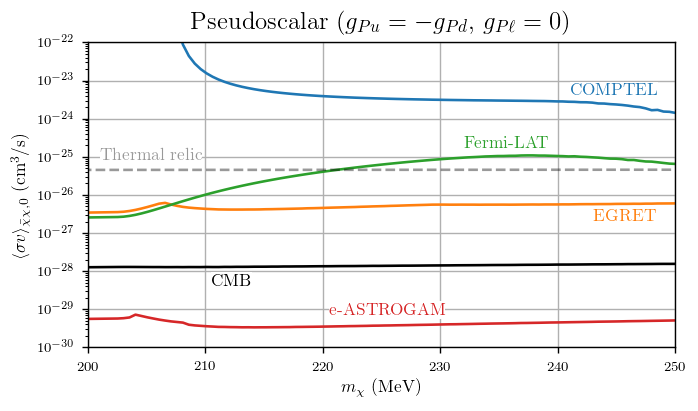

In [68]:
plt.figure(figsize=(latex_text_width_1col,
                    0.6*latex_text_width_1col))

plt.plot(psm_mxs, psm_lims_comptel, label="COMPTEL")
plt.plot(psm_mxs, psm_lims_egret, label="EGRET")
plt.plot(psm_mxs, psm_lims_fermi, label="Fermi")
plt.plot(psm_mxs, psm_lims_e_astrogam, label="e-ASTROGAM")
plt.plot(psm_mxs, psm_lims_cmb, label=r"CMB", color="black")
plt.plot(rd_mxs_s_wave, rd_lims_s_wave, '--', label="Thermal relic",
         color="black", alpha=0.4)

plt.xlim(psm_mxs[[0, -1]])
plt.ylim([1e-30, 1e-22])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")  #  * (v_\chi / v_0)^2
plt.title("Pseudoscalar ($g_{Pu} = -g_{Pd}$, $g_{P\ell} = 0$)")

plt.text(241, 4e-24, "COMPTEL", fontsize=10, color=colors[0],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(243, 2e-27, "EGRET", fontsize=10, color=colors[1],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(232, 1.6e-25, "Fermi-LAT", fontsize=10, color=colors[2],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(220.5, 7e-30, "e-ASTROGAM", fontsize=10, color=colors[3],
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(210.5, 4e-29, "CMB", fontsize=10, color='k',
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))
plt.text(201, 8e-26, "Thermal relic", fontsize=10, color="black", alpha=0.4,
         bbox=dict(facecolor='white', edgecolor='none', pad=0.0))

plt.tight_layout()
plt.savefig("figures/psm_type_III_2HDM_sigmav_limits.pdf")

In [21]:
import os
os.system('say "Done computing limits"')

0

# Vector mediator

In [5]:
def fn_prefix_vector(vm):
    """Prefix for data files and figures.
    """
    if vm.__class__ == KineticMixing:
        fn_prefix_class = "km"
    else:
        fn_prefix_class = "gvu_{}_gvd_{}".format(vm.gvuu, vm.gvdd)
    return "vm_{}_ann_to_{}".format(fn_prefix_class, "med" if vm.mv < 250 else "sm")

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Compute constraints
Redo with $m_V = 125$ MeV?

In [40]:
vm = KineticMixing(mx=1., mv=200., gvxx=1., eps=0.1)
# vm = QuarksOnly(mx=1., mv=500., gvxx=1., gvuu=1., gvdd=-1., gvss=0.)

# Prefix for data files and figures
fn_prefix = fn_prefix_vector(vm)

vm_km_ann_to_med


In [41]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [42]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_target,
                                        bg_model=gc_bg_model)

In [43]:
vm_lims_cmb = vm.cmb_limits(vm_mxs)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [45]:
np.savetxt("data/{}_lims_comptel.csv".format(fn_prefix),
           np.array([vm_mxs, vm_lims_comptel]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_egret.csv".format(fn_prefix),
           np.array([vm_mxs, vm_lims_egret]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_fermi.csv".format(fn_prefix),
           np.array([vm_mxs, vm_lims_fermi]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/{}_lims_e_astrogam.csv".format(fn_prefix),
           np.array([vm_mxs, vm_lims_e_astrogam]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

np.savetxt("data/{}_lims_cmb.csv".format(fn_prefix),
           np.array([vm_mxs, vm_lims_cmb]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Plot constraints

In [176]:
# Load constraints
theories = np.array(
    [[KineticMixing(1., mv, 1., eps=0.1) for mv in [200., 500.]],
     [QuarksOnly(1., mv, 1., gvuu=1., gvdd=-1., gvss=0.) for mv in [200., 500.]],
     [QuarksOnly(1., mv, 1., gvuu=1., gvdd=1., gvss=0.) for mv in [200., 500.]]],
    dtype=np.object)

constraints = np.array(
    [[{} for _ in range(theories.shape[1])] for _ in range(theories.shape[0])],
    dtype=np.object)

for i in range(theories.shape[0]):
    for j in range(theories.shape[1]):
        for c in constraint_names:
            fn = "data/{}_lims_{}.csv".format(fn_prefix_vector(theories[i, j]),
                                              c.lower().replace("-", "_"))
            constraints[i, j][c] = np.loadtxt(fn, delimiter=",")[:, 1]

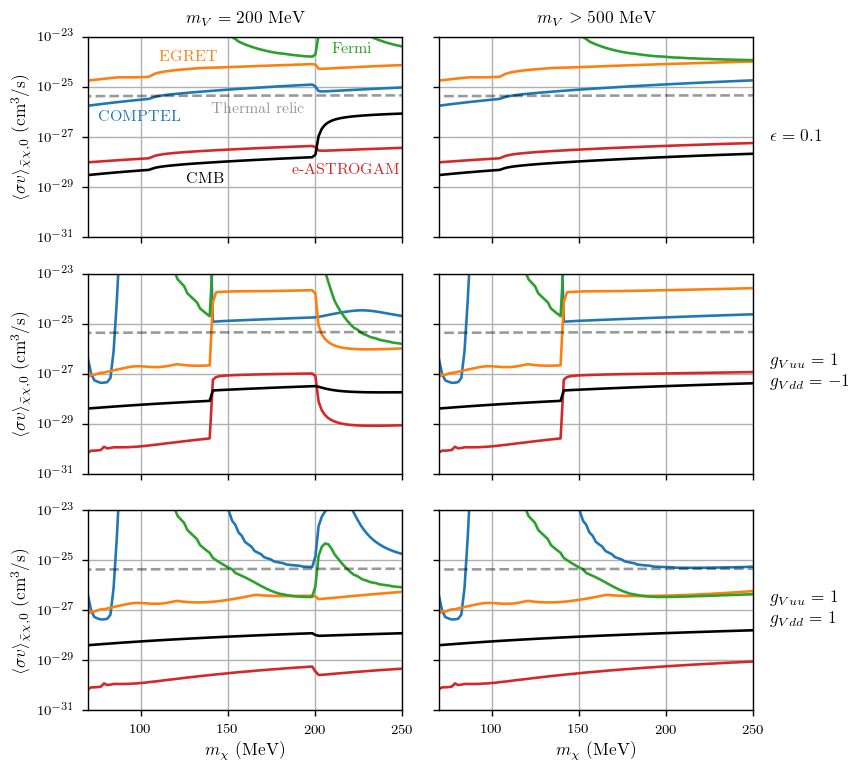

In [179]:
fig, axs = plt.subplots(theories.shape[0], theories.shape[1],
                        sharex=True, sharey=True,
                        figsize=(latex_text_width_1col, 0.9*latex_text_width_1col))

for i in range(theories.shape[0]):
    for j in range(theories.shape[1]):
        ax = axs[i, j]
        
        # Formatting
        if i == theories.shape[0] - 1:
            ax.set_xlabel(r"$m_\chi$ (MeV)")
        if j == 0:
            ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
        ax.set_xlim(vm_mxs[[1, -1]])
        ax.set_ylim([1e-31, 1e-23])
        ax.set_xscale("linear")
        ax.set_yscale("log")
        ax.grid()
        
        # Constraints
        for c in constraint_names:
            color = 'k' if c == "CMB" else None
            ax.plot(vm_mxs, constraints[i, j][c], label=c, color=color)
        
        # Thermal relic cross section
        ax.plot(rd_mxs_s_wave, rd_lims_s_wave, '--', label="Thermal relic",
                color="black", alpha=0.4)
        
ax = axs[0, 0]
ax.text(75, 4e-27, "COMPTEL", fontsize=9, color=colors[0])
ax.text(110, 1e-24, "EGRET", fontsize=9, color=colors[1])
ax.text(210, 2e-24, "Fermi", fontsize=9, color=colors[2])
ax.text(187, 3e-29, "e-ASTROGAM", fontsize=9, color=colors[3])
ax.text(140, 8e-27, "Thermal relic", fontsize=9, alpha=0.4)
ax.text(126, 1.5e-29, "CMB", fontsize=9)
# Label couplings
axs[0, 1].text(260, 1e-27, r"$\epsilon = 0.1$",va="center", fontsize=10)
axs[1, 1].text(260, 1e-27, r"$g_{Vuu} = 1$" + "\n" + r"$g_{Vdd} = -1$",
               va="center", fontsize=10)
axs[2, 1].text(260, 1e-27, r"$g_{Vuu} = 1$" + "\n" + r"$g_{Vdd} = 1$",
               va="center", fontsize=10)
# Label mediator masses
axs[0, 0].set_title(r"$m_V = %i$ MeV" % 200., fontsize=10)
axs[0, 1].set_title(r"$m_V > 500$ MeV", fontsize=10)

fig.tight_layout()
fig.savefig("figures/vm_sigmav_limits.pdf")

In [102]:
os.system('say "Done computing limits"')

0

## Look at how e-ASTROGAM and CMB constraints vary with couplings

In [52]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=1.,
                    gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

# Coupling ratios
ratios = np.array([-2, -1., 0., 0.25, 0.5, 0.75, 1.])

# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [53]:
# Compute ASTROGAM limits for the different couplings
vm_lims_e_astrogam_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_e_astrogam_gvdd.append(vm.unbinned_limits(vm_mxs,
                                                      target_params=gc_target,
                                                      bg_model=gc_bg_model))

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  return prefactor * n_sigma / (-limit_obj.fun)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:235: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:239: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


In [60]:
# Compute CMB limits for the different couplings
vm_lims_cmb_gvdd = []

for ratio in ratios:
    vm.gvdd = ratio * vm.gvuu
    vm_lims_cmb_gvdd.append(vm.cmb_limits(vm_mxs))

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return 4.1e-31 * self.mx / self.f_eff(x_kd)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the in

In [61]:
os.system('say "Done computing CMB limits"')

0

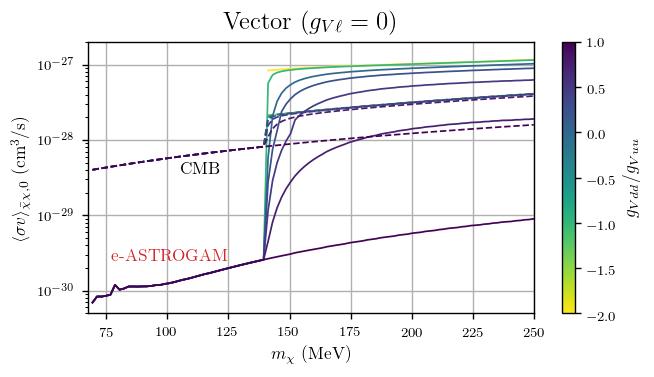

In [94]:
plt.figure(figsize=(latex_text_width_1col, 0.5*latex_text_width_1col))

for i, (ratio, lims, cmb) in enumerate(zip(ratios,
                                      vm_lims_e_astrogam_gvdd,
                                      vm_lims_cmb_gvdd)):
    plt.plot(vm_mxs, lims, color=m.to_rgba(ratio), linewidth=1)
    plt.plot(vm_mxs, cmb, '--', color=m.to_rgba(ratio), alpha=1, linewidth=1)

plt.text(105, 3.5e-29, "CMB", fontdict={"fontsize": 10})
plt.text(77, 2.5e-30, "e-ASTROGAM",
         fontdict={"fontsize": 10,
                   "color": plt.rcParams['axes.prop_cycle'].by_key()['color'][3]})

# Formatting
plt.xlim(vm_mxs[[0, -1]])
plt.ylim([5e-31, 2e-27])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ (cm$^3$/s)")
plt.title(r"Vector ($g_{V\ell} = 0$)")
# plt.legend()

plt.gcf().colorbar(m, ax=plt.gca()).set_label(r"$g_{Vdd} / g_{Vuu}$")

plt.savefig("figures/vm_sigmav_limits_coupling_dependence.pdf")

# Minimal examples of how to set limits
Any of the three blocks below can be run without needing to set anything else up.

Unbinned (ie, projected) limits:

In [9]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_parameters import (gc_target, gc_bg_model,
                                        A_eff_e_astrogam, energy_res_e_astrogam,
                                        T_obs_e_astrogam)

mxs = np.linspace(70., 250., 3)

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)

sm_lims_e_astrogam = sm.unbinned_limits(mxs, target_params=gc_target, bg_model=gc_bg_model,
                                        A_eff=A_eff_e_astrogam,
                                        energy_res=energy_res_e_astrogam,
                                        T_obs=T_obs_e_astrogam)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:235: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:239: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


Binned limits (ie, using current data from Fermi, COMPTEL or EGRET):

In [10]:
import numpy as np
from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_parameters import egret_diffuse

sm = ScalarMediator(mx=1., ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
mxs = np.linspace(70., 250., 3)

sm_lims_egret = sm.binned_limits(mxs, egret_diffuse)

Effective areas

Text(0,0.5,'$A_{\\mathrm{eff}}$ (cm$^2$)')

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


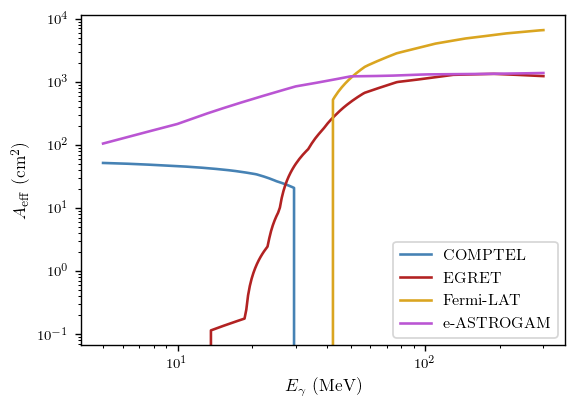

In [4]:
import numpy as np
from hazma.gamma_ray_parameters import (A_eff_comptel, A_eff_egret,
                                        A_eff_fermi, A_eff_e_astrogam)

e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

plt.plot(e_gams, A_eff_comptel(e_gams), label="COMPTEL")
plt.plot(e_gams, A_eff_egret(e_gams), label="EGRET")
plt.plot(e_gams, A_eff_fermi(e_gams), label="Fermi-LAT")
plt.plot(e_gams, A_eff_e_astrogam(e_gams), label="e-ASTROGAM")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$A_{\mathrm{eff}}$ (cm$^2$)")